<a href="https://colab.research.google.com/github/zama-sarib/Youtube-Comment-Clustering/blob/main/YoutubeComment_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mounting GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing necessary Libraries

In [ ]:
!pip3 install spacy_langdetect
import numpy as np
import pandas as pd
import seaborn as sns
from string import punctuation
import re
import os
from tqdm import tqdm 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import missingno as msno
from spacy_langdetect import LanguageDetector
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import matplotlib as mpl
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline
mpl.rcParams['figure.figsize'] = (14, 6)
mpl.rcParams['axes.grid'] = True
sns.set_style("darkgrid")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/YouTubeComment/preprocessedcomment.csv")
print(data.shape)
data.head()

(496425, 3)


,user_id,comment,likes
0,Pankaj Rana,"If this year Asus didn't bring us new 5,000 -...",52
1,Alex Shimla,Only samsung was one vendor that was not push...,0
2,Shubham Sanket Swain,Want to know about updates. By the way does t...,0
3,Aniket Kalbhor,Amazing piece of Tech,0
4,Twitch- xjuiceboxtwitch,JUST BOUGHT BLUE 1,1.0


### Adding some basic features such as wordCount, charCount, PuncCount, WordDensity

In [ ]:
safe_div = 0.001
data['word_count'] = data['comment'].apply(lambda x:len(x.split(" ")))
data['char_count'] = data['comment'].apply(lambda x:len(x.replace(" ","")))
data['word_density'] = data['word_count']/(data['char_count']+safe_div)
data['punc_count'] = data['comment'].apply(lambda x : len([a for a in x if a in punctuation]))
data['stopwords_count'] = data['comment'].apply(lambda x:len([word for word in x.split(" ") if word in stopwords.words('english')]))
data['likes'] = data['likes'].str.rstrip('K').astype(float)

In [ ]:
data.head()

,user_id,comment,likes,word_count,char_count,word_density,punc_count,stopwords_count
0,Pankaj Rana,"If this year Asus didn't bring us new 5,000 -...",52.0,70,327,0.214067,15,21
1,Alex Shimla,Only samsung was one vendor that was not push...,0.0,29,126,0.230157,7,11
2,Shubham Sanket Swain,Want to know about updates. By the way does t...,0.0,16,66,0.242421,2,7
3,Aniket Kalbhor,Amazing piece of Tech,0.0,4,18,0.222210,0,1
4,Twitch- xjuiceboxtwitch,JUST BOUGHT BLUE 1,1.0,4,15,0.266649,0,0


In [ ]:
# Dropping all rows where word_count > char_count
print(data.shape[0])
data = data[data['word_count']<data['char_count']]
print(data.shape[0])

496425
496265


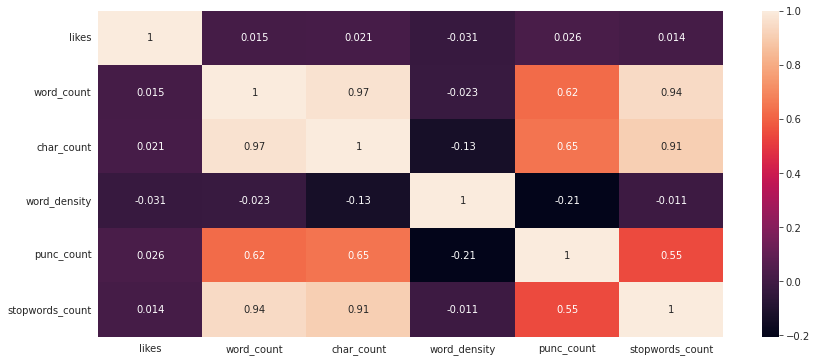

In [ ]:
sns.heatmap(data.corr(),annot=True)

In [174]:
# data.to_csv("/content/drive/MyDrive/YouTubeComment/basic_feature_data.csv",index=False)
dir = "/content/drive/MyDrive/YouTubeComment/basic_feature_data.csv"
if not os.path.isfile(dir):
    print("Saving...")
    data.to_csv("/content/drive/MyDrive/YouTubeComment/basic_feature_data.csv",index=False)
    print("File Saved.")
else:
    print("File already exist !!")

File already exist !!


In [ ]:
def utilityPlot(data,feature):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
    sns.set_style("darkgrid")
    plt.figure(figsize=(10,6))
    sns.boxplot(np.sort(data[feature]),ax=ax1)
    sns.violinplot(np.sort(data[feature]),ax=ax2)
    ax1.set_xlabel('index')
    ax1.set_ylabel("Count")
    ax1.set_title(feature)

    ax2.set_xlabel('index')
    ax2.set_ylabel("Count")
    ax2.set_title(feature)
    plt.show()

    print()
    print("*"*130)
    perc_feature = np.percentile(data[feature].values,[0,25,50,75,100])
    i = 0
    for percentile in perc_feature:
        print("{} percentile value of {}: {}".format(i,feature,percentile))
        i += 25
    print("*"*130)
    print()

## Some Important plot for numerical features

### Analysing Word Count Feature.

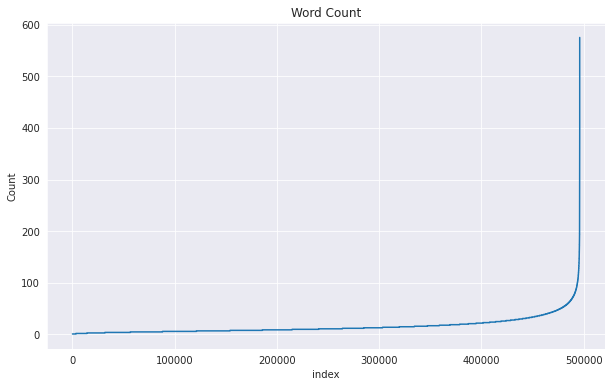

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
plt.plot(np.sort(data['word_count']))
plt.xlabel('index')
plt.ylabel("Count")
plt.title("Word Count")
plt.show()

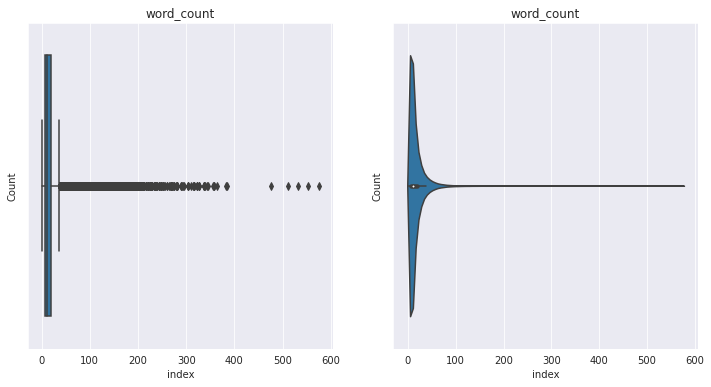

<Figure size 720x432 with 0 Axes>


**********************************************************************************************************************************
0 percentile value of word_count: 1.0
25 percentile value of word_count: 7.0
50 percentile value of word_count: 11.0
75 percentile value of word_count: 19.0
100 percentile value of word_count: 575.0
**********************************************************************************************************************************



In [ ]:
utilityPlot(data,'word_count')

## Observation



1.   Word Count feature follows pareto distribution(80-20)
2.   The median value of word count is around 11 words.
3.   Average comment is around 10 words in length. Which means most of the comments is straight forward concern or straight forward line of thought.

4. There are almost 5k comments where the number of words are very large and it is likely that the user is posing detailed queries in the comment section.





### Analysing Likes Feature.

Text(0.5, 1.0, 'Count of Likes')

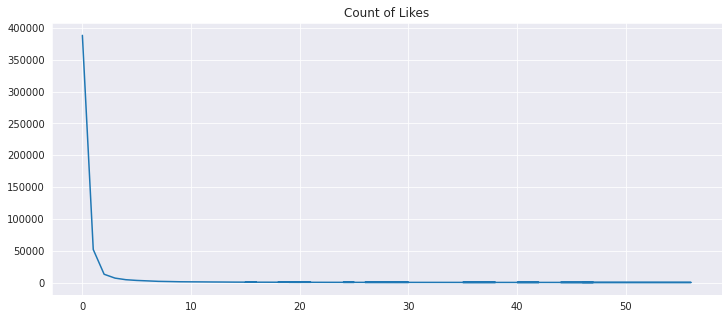

In [ ]:
plt.figure(figsize=(12,5))
data['likes'].value_counts().head(50).plot()
plt.title("Count of Likes")

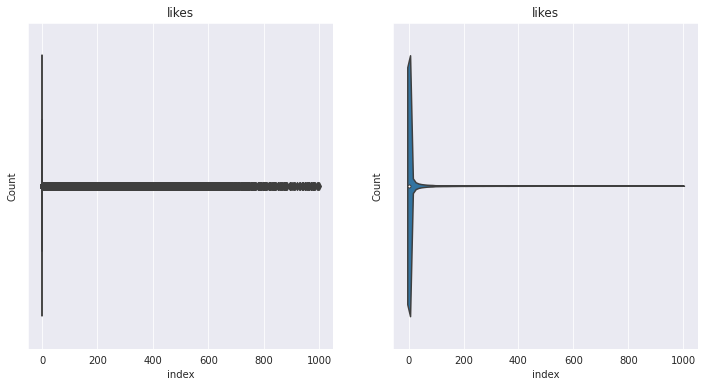

<Figure size 720x432 with 0 Axes>


**********************************************************************************************************************************
0 percentile value of likes: 0.0
25 percentile value of likes: 0.0
50 percentile value of likes: 0.0
75 percentile value of likes: 0.0
100 percentile value of likes: 998.0
**********************************************************************************************************************************



In [ ]:
utilityPlot(data,'likes')

What distribution does 'Likes' feature folows?

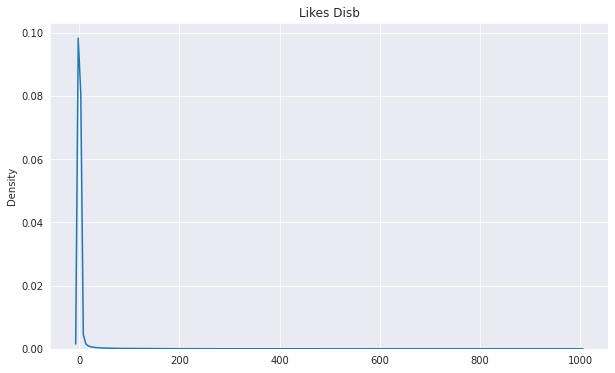

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data['likes'].values)
plt.title("Likes Disb")
plt.show()


## Observation



1.   'Likes' feature is heavily right skewed.
2.   The median value of 'Likes' is around 0 per comment.
3.   Most of the comment doesn't have any likes.(User tends to like very few comment of othere user which are important for them and hence likes feature could be an important feature to segregate the different and important comments from the rest. 





### Analysing character count Feature.

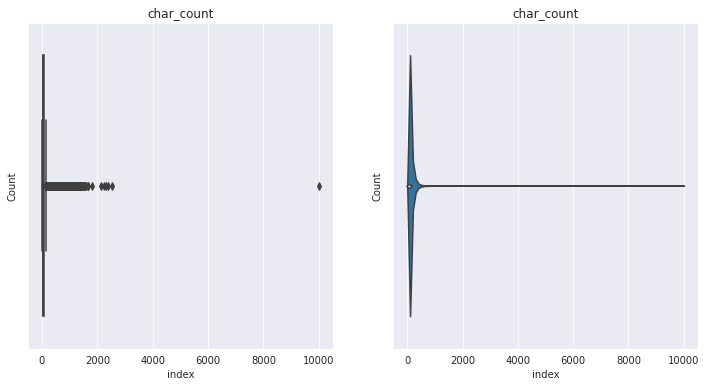

<Figure size 720x432 with 0 Axes>


**********************************************************************************************************************************
0 percentile value of char_count: 3.0
25 percentile value of char_count: 28.0
50 percentile value of char_count: 47.0
75 percentile value of char_count: 82.0
100 percentile value of char_count: 9999.0
**********************************************************************************************************************************



In [ ]:
utilityPlot(data,'char_count')


## Observation



1.   'char_count' feature has a skewed distribution(80-20)
2.   The median value of 'Likes' is around 46 char as opposed to 11 words count per comment.
3.   Average char count is around 46 per comment. 





### How much is the word_count and char_count overlap?
It may help use to understand how much important words are present if we assume the unimportant word have small character count(eg. as, in, the, a, is etc)

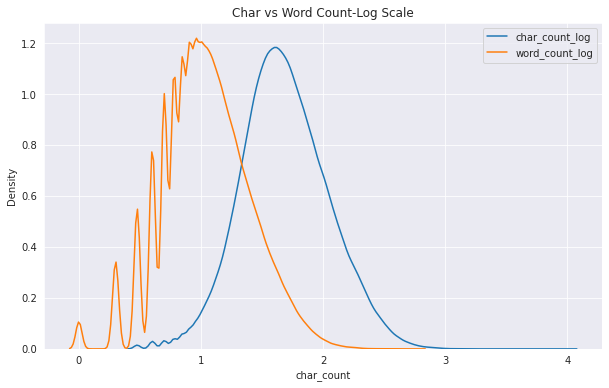

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(np.log10(data['char_count']+0.00001),label='char_count_log')
sns.kdeplot(np.log10(data['word_count']+0.00001),label='word_count_log')
plt.title("Char vs Word Count-Log Scale")
plt.legend(loc='best')
plt.show()

[]

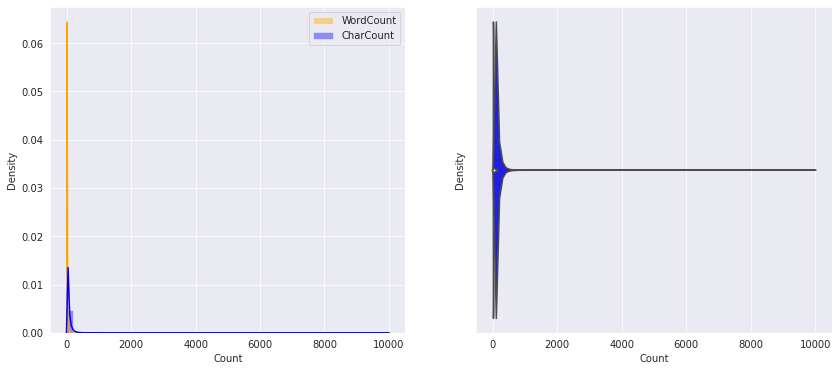

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2)
sns.distplot(data['word_count'],ax=ax1,color='orange',label='WordCount')
sns.distplot(data['char_count'],ax=ax1,color='blue',label='CharCount')
ax1.set_xlabel("Count")
ax1.set_ylabel("Density")
ax1.legend()

sns.violinplot(data['word_count'].values,ax=ax2,color='orange')
sns.violinplot(data['char_count'].values,ax=ax2,color='blue')
ax2.set_xlabel("Count")
ax2.set_ylabel("Density")

plt.plot()

Observation:
1. We can see from the first plot that word count has a higher density and peaked around 0-10 while the char count has a heavy tail distribution. Hence we can say there are important words in the comment and not just 2-3 character unimportant(stop words).

### Analysing Word Density Feature.

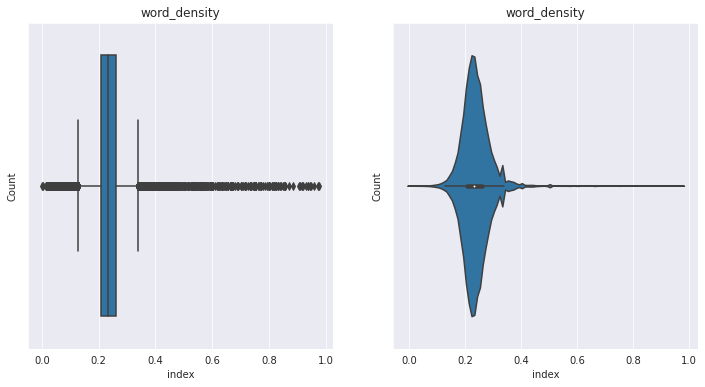

<Figure size 720x432 with 0 Axes>


**********************************************************************************************************************************
0 percentile value of word_density: 0.0002000199819962014
25 percentile value of word_density: 0.20689298460371375
50 percentile value of word_density: 0.23170449140864136
75 percentile value of word_density: 0.25999480010399795
100 percentile value of word_density: 0.9755978585627004
**********************************************************************************************************************************



In [ ]:
utilityPlot(data,'word_density')


## Observation



1.   'word_density' feature has a heavily right skewed distribution.
2.   The median value of 'word density' is around 0.23.





### Analysing Punctuation Count Feature.

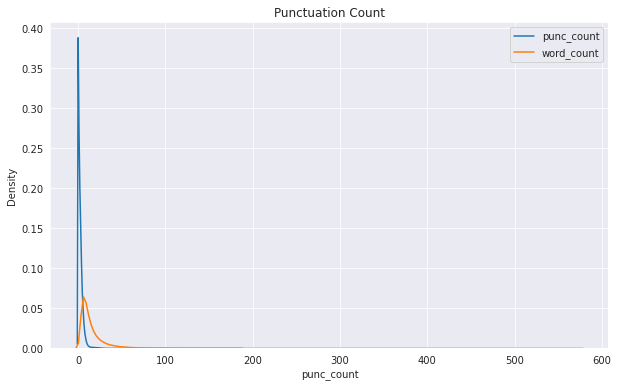

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data['punc_count'],label='punc_count')
sns.kdeplot(data['word_count'],label='word_count')
plt.title("Punctuation Count")
plt.legend()
plt.show()

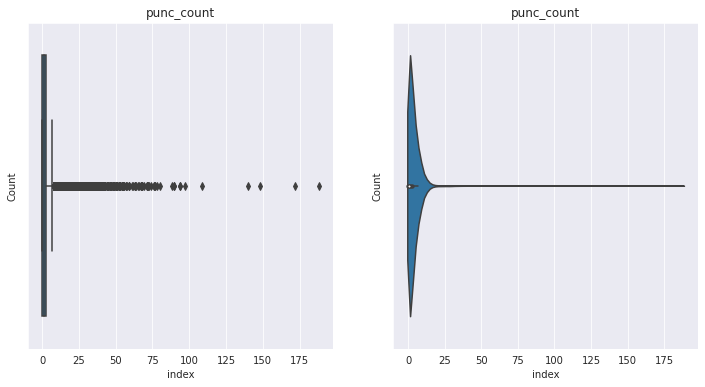

<Figure size 720x432 with 0 Axes>


**********************************************************************************************************************************
0 percentile value of punc_count: 0.0
25 percentile value of punc_count: 0.0
50 percentile value of punc_count: 1.0
75 percentile value of punc_count: 3.0
100 percentile value of punc_count: 188.0
**********************************************************************************************************************************



In [ ]:
utilityPlot(data,'punc_count')


## Observation



1.   'punc_count' feature has a skewed distribution.
2.   The median value of 'punc_count' is around 1. There are in general 1 punctutaion marks in the sentence.
3. In English literature punctuation mark typically translate to more expressive and more structurally correct. Hence if the comment is grammatically correct that could means that it is intented for some series remark/query or annotation.





### Analysing Stop Word Count Feature.

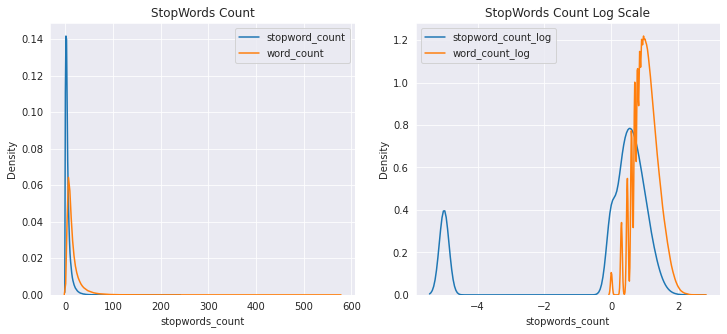

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
sns.kdeplot(data['stopwords_count'],label='stopword_count',ax=ax1)
sns.kdeplot(data['word_count'],label='word_count',ax=ax1)
ax1.set_title("StopWords Count")
ax1.legend()

sns.kdeplot(np.log10(data['stopwords_count']+0.00001),label='stopword_count_log',ax=ax2)
sns.kdeplot(np.log10(data['word_count']+0.00001),label='word_count_log',ax=ax2)
ax2.set_title("StopWords Count Log Scale")
ax2.legend()
plt.show()

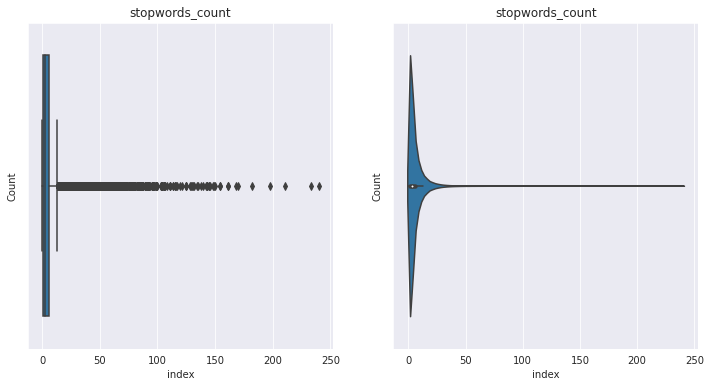

<Figure size 720x432 with 0 Axes>


**********************************************************************************************************************************
0 percentile value of stopwords_count: 0.0
25 percentile value of stopwords_count: 1.0
50 percentile value of stopwords_count: 3.0
75 percentile value of stopwords_count: 6.0
100 percentile value of stopwords_count: 240.0
**********************************************************************************************************************************



In [ ]:
utilityPlot(data,'stopwords_count')


## Observation



1.   'Stop_word_count' feature has a skewed distribution.
2.   The median value of 'Stop_word_count' is around 8. There are in general 8 Stop words in the sentence in an average of 11 words comment. That means most of the word in the comment is not that useful.





In [ ]:
data.head()

,user_id,comment,likes,word_count,char_count,word_density,punc_count,stopwords_count
0,Pankaj Rana,"If this year Asus didn't bring us new 5,000 -...",52.0,70,327,0.214067,15,21
1,Alex Shimla,Only samsung was one vendor that was not push...,0.0,29,126,0.230157,7,11
2,Shubham Sanket Swain,Want to know about updates. By the way does t...,0.0,16,66,0.242421,2,7
3,Aniket Kalbhor,Amazing piece of Tech,0.0,4,18,0.222210,0,1
4,Twitch- xjuiceboxtwitch,JUST BOUGHT BLUE 1,1.0,4,15,0.266649,0,0


In [ ]:
def preprocess(x):

    SAFE_DIV = 0.0001 
    STOP_WORDS = stopwords.words('english')

    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [ ]:
def plotWordCloud(text_corpus):
    comment_words = ''
    stopwords = set(STOPWORDS)
    for val in text_corpus:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
        
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

    plt.figure(figsize = (10, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()


# Analysing all the comment with more likes(>100 likes).

In [ ]:
def creat_text_corpus_likes(data,col):
    more_like = data[data[col]>100]
    text_corpus = []
    for text in tqdm(more_like['comment'].values):
        text_corpus.append(preprocess(text))

    return text_corpus

100%|██████████| 4874/4874 [00:02<00:00, 1773.00it/s]


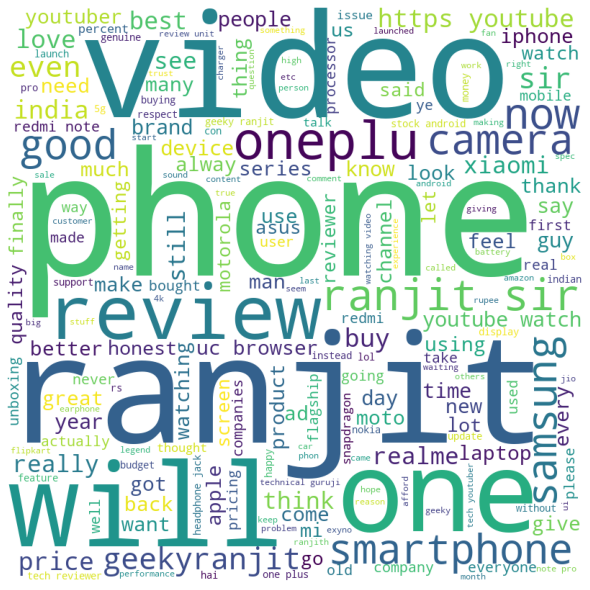

In [ ]:
text_corpus = []
col = 'likes'
text_corpus = creat_text_corpus_likes(data,col)
plotWordCloud(text_corpus)


> People likes to talk about phone, camera, review/videos by the creator
> The most liked brand are Oneplus, Redmi, Samsung, Realme, Motorola
> People generally agrees to other comments which talk about the honest and impactful reviews as posted by the creator.



In [ ]:
# def isEnglishComment(comments):
#     nlp = spacy.load('en')
#     bool_array = []
#     for comment in comments:
#         doc = nlp(comment)
#         detect_language = doc._.language
#         if detect_language['language'] =='en' : #or detect_language['score'] >= 0.4:
#             bool_array.append(True)
#         else:
#             bool_array.append(False)

#     return np.array(bool_array)

In [ ]:
# filt = isEnglishComment(data['comment'])

In [ ]:
# data_eng_comment = data[filt]
# print(data_eng_comment.shape)
# data_eng_comment.head()

# Analysing all the comment.

In [ ]:
def creat_text_corpus(data,col):
    text_corpus = []
    for text in tqdm(data['comment'].values):
        text_corpus.append(preprocess(text))

    return text_corpus

100%|██████████| 496265/496265 [04:35<00:00, 1800.13it/s]


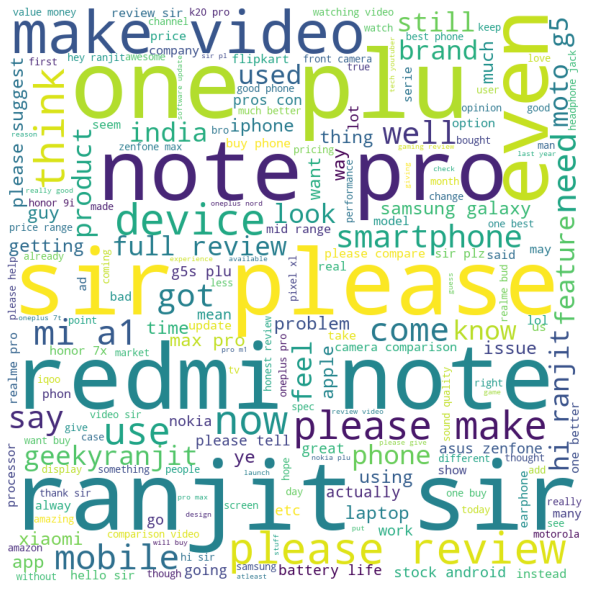

In [ ]:
text_corpus = []
col = 'comment'
text_corpus = creat_text_corpus(data,col)
plotWordCloud(text_corpus)



> Observation

*   There are various product likes phones, laptop, watches(smart watches), Earphone which are mostly discussed in the comment section as the data was fetched from the tech related channel
*   The important aspect people often talk about are:

>1. Design
>2. Screen quality
>3. Pricing
>4. Updates
>5. Battery Life
>6. Price


*   It seems people it also matters a lot for people from which online platform are they buying product and which one is offering them best deals.













# Mobile related Comments.

### How many comments are for mobile phone?

In [ ]:
pattern = re.compile(r'mobile|phone|cell')
mobile_mask = data['comment'].str.contains(pattern) == True
mobile_data = data[mobile_mask]

In [170]:
print('-'*150)
print("Number of datapoint talking about phones are: {}".format(mobile_data.shape[0]))
print("'%' of datapoint talking about phones are: {0:.2f}%".format((mobile_data.shape[0]/data.shape[0])*100))
print('-'*150)
mobile_data.head()

------------------------------------------------------------------------------------------------------------------------------------------------------
Number of datapoint talking about phones are: 96069
'%' of datapoint talking about phones are: 19.36%
------------------------------------------------------------------------------------------------------------------------------------------------------


,user_id,comment,likes,word_count,char_count,word_density,punc_count,stopwords_count
0,Pankaj Rana,"If this year Asus didn't bring us new 5,000 -...",52.0,70,327,0.214067,15,21
16,Hamaad Salif,flodable phone,0.0,2,13,0.153834,0,0
20,Mohak Tyagi,.. He doesn't even want to do the review of th...,0.0,55,202,0.272276,25,20
26,All about technology 24x7,450 !! Grow up samsung. Tht experience ui wil...,0.0,90,388,0.231958,10,34
34,ARUN Ma,my favorite mobile is Moto now. I am using Mo...,9.0,16,54,0.296291,2,4


### Word Cloud disb of comments for MobilePhones related comments

100%|██████████| 96069/96069 [00:55<00:00, 1735.22it/s]


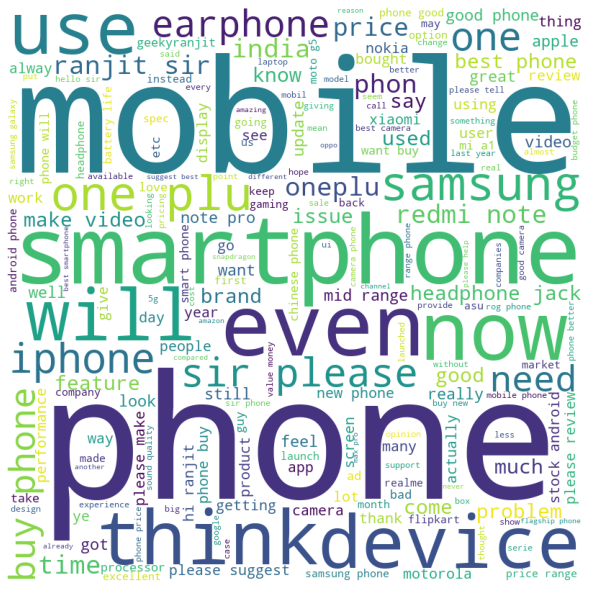

In [ ]:
text_corpus = []
col = 'comment'
text_corpus = creat_text_corpus(mobile_data,col)
plotWordCloud(text_corpus)

# How many comments are for Computer/laptop phone?

In [ ]:
pattern = re.compile(r'pc|comp|lappy|laptop|workstation')
comp_mask = data['comment'].str.contains(pattern)==True
comp_data = data[comp_mask]

### How many comments are for mobile phone?

In [172]:
print('-'*150)
print("Number of datapoint talking about phones are: {}".format(comp_data.shape[0]))
print("'%' of datapoint talking about phones are: {0:.2f}%".format((comp_data.shape[0]/data.shape[0])*100))
print('-'*150)
comp_data.head()

------------------------------------------------------------------------------------------------------------------------------------------------------
Number of datapoint talking about phones are: 44486
'%' of datapoint talking about phones are: 8.96%
------------------------------------------------------------------------------------------------------------------------------------------------------


,user_id,comment,likes,word_count,char_count,word_density,punc_count,stopwords_count
8,Srinu Srinu,Love you ranjit. I have been following you for...,1.0,22,99,0.222220,4,9
10,Sumit Ranjan Singh,awsm review sir.....\nSir I want a comparison ...,1.0,16,72,0.222219,6,4
28,TRAVELLERSID21,"For what you said in the start, You earned a...",0.0,29,106,0.273582,5,13
66,Tech DEEM,Please review MSI Modern B4M 14 ryzen 5 4500u...,0.0,13,55,0.236359,3,0
139,Suman Das,awesomelaptop,0.0,1,13,0.076917,0,0


### Word Cloud disb of comments for computer/Laptop related comments

100%|██████████| 44486/44486 [00:25<00:00, 1766.48it/s]


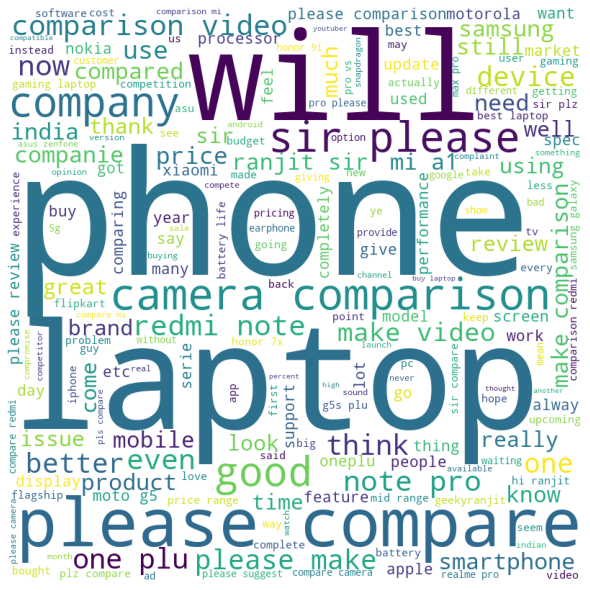

In [ ]:
text_corpus = []
col = 'comment'
text_corpus = creat_text_corpus(comp_data,col)
plotWordCloud(text_corpus)